**Installing pyspark**

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=769c5eca47d6731810c93ff74af9c093d5aa0753b03abd0da1efcbf08f07ba00
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


**Create a spark session**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, BooleanType

spark = SparkSession.builder.appName("Crime data ML").getOrCreate()

**Import the required dataset**

In [10]:
df = spark.read.csv("Crimes_-_2001_to_Present.csv", header=True, inferSchema=True)


**Show schema and rows**

In [11]:
df.show()
df.printSchema()
print(f"Number of rows: {df.count()}")

+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|11037294|   JA371270|03/18/2015 12:00:...|   0000X W WACKER DR|1153|DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|                BANK|

**Drop the na values and filter required data**

In [ ]:
df1=df.na.drop()


In [ ]:
df1.describe().show()

+-------+-------------------+-----------+--------------------+------------------+-----------------+-----------------+--------------------+--------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+-------------------+--------------------+
|summary|                 ID|Case Number|                Date|             Block|             IUCR|     Primary Type|         Description|Location Description|              Beat|         District|              Ward|    Community Area|          FBI Code|      X Coordinate|      Y Coordinate|              Year|          Updated On|           Latitude|          Longitude|            Location|
+-------+-------------------+-----------+--------------------+------------------+-----------------+-----------------+--------------------+--------------------+------------------+-----------------+------------------

In [ ]:
df1.show()

+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|12045583|   JD226426|05/07/2020 10:24:...| 035XX S INDIANA AVE|0820|               THEFT|      $500 AND UNDER|           AP

**Encoding the feature variables**

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col


# Convert boolean "Arrest" column to string
df1 = df1.withColumn("Arrest", col("Arrest").cast("string"))
df1 = df1.withColumn("Domestic", col("Domestic").cast("string"))

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Columns to apply label encoding
columns_to_encode = ["Primary Type", "Description","Arrest", "Domestic", "FBI Code", "Year"]


# Create a StringIndexer for each column
indexers = [StringIndexer(inputCol=col, outputCol=col+"_encoded", handleInvalid="skip") for col in columns_to_encode]

# Create a pipeline to execute the StringIndexers
pipeline = Pipeline(stages=indexers)

# Fit and transform the data using the pipeline
df2 = pipeline.fit(df1).transform(df1)

# Show the result
df2.show(10)


+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+--------------------+-------------------+--------------+----------------+----------------+------------+
|      ID|Case Number|                Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|Primary Type_encoded|Description_encoded|Arrest_encoded|Domestic_encoded|FBI Code_encoded|Year_encoded|
+--------+-----------+--------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------

In [ ]:
df2.printSchema()




root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Primary Type_encoded: double (nullable = false)
 |-- Description_encoded: double (nullable = f

**Making the correlation matrix to get relation between feature and target variable**

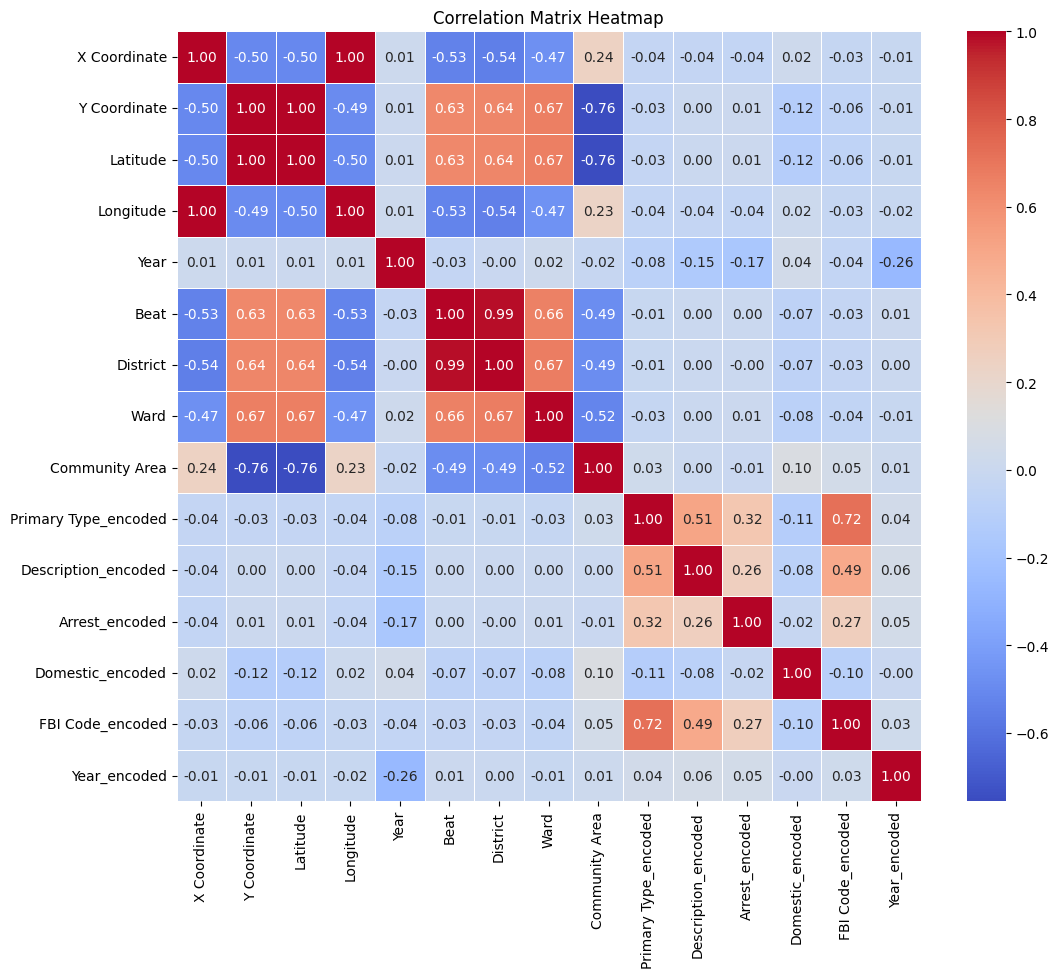

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation



# Assuming you already have a DataFrame named 'crime_df', replace it with your actual DataFrame
# crime_df = ...

# Select the numerical and encoded categorical columns for which you want to compute the correlation matrix
numeric_cols = ["X Coordinate", "Y Coordinate", "Latitude", "Longitude", "Year", "Beat", "District", "Ward", "Community Area", "Primary Type_encoded", "Description_encoded", "Arrest_encoded", "Domestic_encoded", "FBI Code_encoded", "Year_encoded"]

# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
assembled_df = assembler.transform(df2.select(numeric_cols))

# Select only the assembled features column
selected_data = assembled_df.select("features")

# Compute the correlation matrix
correlation_matrix = Correlation.corr(selected_data, "features").head()

# Extract the correlation matrix as a NumPy array
corr_matrix_array = correlation_matrix[0].toArray()

# Convert the correlation matrix to a Pandas DataFrame
corr_df = pd.DataFrame(corr_matrix_array, columns=numeric_cols, index=numeric_cols)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix Heatmap")
plt.show()




**Task to perform: This is a classification problem where we try to predict the primary type of crime and other factors such as arrest using various spark ML algorithms**

**Target variable used: Primary type of crime
Features used:Description, Arrest,FBI Codes, Year,Domestic**

**1. Random Forest Classifier**

In [ ]:
###Random forest


from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("RandomForestExample").getOrCreate()



# Assemble feature vectors
feature_columns = ["Primary Type_encoded", "Description_encoded", "Arrest_encoded", "Domestic_encoded", "FBI Code_encoded", "Year_encoded"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df2_assembled = assembler.transform(df2)

# Split the data into training and testing sets
(train_data, test_data) = df2_assembled.randomSplit([0.8, 0.2], seed=123)

# Define and train the Random Forest Classifier
rf = RandomForestClassifier(labelCol="Primary Type_encoded", featuresCol="features", numTrees=10, maxBins=540)

model = rf.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Primary Type_encoded", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Additional metrics: precision, recall, F1 score
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")




Accuracy: 0.7430389642651002
Precision: 0.6897657098631206
Recall: 0.7430389642651002
F1 Score: 0.7004212196572129


**2. Logistic Regression**

In [ ]:
###Logistic Regression

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


label_col = 'Primary Type_encoded'

# Create a feature vector without explicitly creating an output column
feature_cols = [
    'Description_encoded',
    'Arrest_encoded',
    'Domestic_encoded',
    'FBI Code_encoded',
    'Year_encoded'
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
lr = LogisticRegression(featuresCol="features", labelCol=label_col)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, lr])

# Split the data into training and testing sets
(train_data, test_data) = df2.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Precision, Recall, and F1 Score
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Weighted Precision: {precision:.4f}')
print(f'Weighted Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.5864
Weighted Precision: 0.5831
Weighted Recall: 0.5864
F1 Score: 0.5369


**3. Support Vector Classifier**

In [ ]:
###Linear SVC

from pyspark.ml.classification import LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator



# Assemble features
feature_cols = ['Primary Type_encoded', 'Description_encoded', 'Domestic_encoded', 'FBI Code_encoded', 'Year_encoded']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='svc_features')

# Convert the 'Arrest' column to a numeric type
label_indexer = StringIndexer(inputCol='Arrest', outputCol='label_arrest')  # Choose a different name

# Create LinearSVC classifier
svc = LinearSVC(maxIter=10, regParam=0.1, labelCol='label_arrest', featuresCol='svc_features')

# Create pipeline
pipeline_svc = Pipeline(stages=[assembler, label_indexer, svc])

# Split the data into training and testing sets
train_data_svc, test_data_svc = df2.randomSplit([0.8, 0.2], seed=42)

# Fit the model
model_svc = pipeline_svc.fit(train_data_svc)

# Make predictions on the test data
predictions_svc = model_svc.transform(test_data_svc)

# Evaluate the model
evaluator_svc = MulticlassClassificationEvaluator(labelCol='label_arrest', predictionCol='prediction', metricName='accuracy')
accuracy_svc = evaluator_svc.evaluate(predictions_svc)
print(f'Accuracy: {accuracy_svc}')

# Calculate precision, recall, and F1-score
precision_svc = evaluator_svc.evaluate(predictions_svc, {evaluator_svc.metricName: 'weightedPrecision'})
recall_svc = evaluator_svc.evaluate(predictions_svc, {evaluator_svc.metricName: 'weightedRecall'})
f1_svc = evaluator_svc.evaluate(predictions_svc, {evaluator_svc.metricName: 'f1'})

# Display precision, recall, and F1-score
print(f'Precision: {precision_svc}')
print(f'Recall: {recall_svc}')
print(f'F1-score: {f1_svc}')

# Show confusion matrix
conf_matrix_svc = predictions_svc.groupBy('Arrest', 'prediction').count()
conf_matrix_svc.show()


Accuracy: 0.8507969346426177
Precision: 0.7238554239972748
Recall: 0.8507969346426177
F1-score: 0.7822094476691456
+------+----------+------+
|Arrest|prediction| count|
+------+----------+------+
|  true|       0.0| 20482|
| false|       0.0|116794|
+------+----------+------+



**4. Gradient Boosting Classifier**

In [ ]:
###GBT Classifier

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator



# Assemble features
feature_cols = ['Primary Type_encoded', 'Description_encoded', 'Domestic_encoded', 'FBI Code_encoded', 'Year_encoded']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features5')

# Convert the 'Arrest' column to a numeric type
label_indexer = StringIndexer(inputCol='Arrest', outputCol='label_arrest')  # Choose a different name

# Create GBT classifier with an increased maxBins value
gbt = GBTClassifier(labelCol='label_arrest', featuresCol='features5', maxBins=512, maxIter=10)  # Adjust maxBins value

# Create pipeline
pipeline = Pipeline(stages=[assembler, label_indexer, gbt])

# Split the data into training and testing sets
train_data, test_data = df2.randomSplit([0.8, 0.2], seed=42)

# Fit the model
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol='label_arrest', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f'Accuracy: {accuracy}')

# Calculate precision, recall, and F1-score
precision = evaluator.evaluate(predictions, {evaluator.metricName: 'weightedPrecision'})
recall = evaluator.evaluate(predictions, {evaluator.metricName: 'weightedRecall'})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: 'f1'})

# Display precision, recall, and F1-score
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

# Show confusion matrix
conf_matrix = predictions.groupBy('Arrest', 'prediction').count()
conf_matrix.show()


Accuracy: 0.9203939508726944
Precision: 0.9195334300675728
Recall: 0.9203939508726945
F1-score: 0.9109829956415374
+------+----------+------+
|Arrest|prediction| count|
+------+----------+------+
|  true|       1.0| 10630|
|  true|       0.0|  9852|
| false|       1.0|  1076|
| false|       0.0|115718|
+------+----------+------+



**5. Naive Bayes**

In [ ]:
###Naive Bayes

from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Assemble features
feature_cols = ['Primary Type_encoded', 'Description_encoded', 'Domestic_encoded', 'FBI Code_encoded', 'Year_encoded']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='nb_features')

# Convert the 'Arrest' column to a numeric type
label_indexer = StringIndexer(inputCol='Arrest', outputCol='label_arrest')  # Choose a different name

# Create Naive Bayes classifier
nb = NaiveBayes(smoothing=1.0, modelType='multinomial', labelCol='label_arrest', featuresCol='nb_features')

# Create pipeline
pipeline_nb = Pipeline(stages=[assembler, label_indexer, nb])

# Split the data into training and testing sets
train_data_nb, test_data_nb = df2.randomSplit([0.8, 0.2], seed=42)

# Fit the model
model_nb = pipeline_nb.fit(train_data_nb)

# Make predictions on the test data
predictions_nb = model_nb.transform(test_data_nb)

# Evaluate the model
evaluator_nb = MulticlassClassificationEvaluator(labelCol='label_arrest', predictionCol='prediction', metricName='accuracy')
accuracy_nb = evaluator_nb.evaluate(predictions_nb)
print(f'Accuracy: {accuracy_nb}')

# Calculate precision, recall, and F1-score
precision_nb = evaluator_nb.evaluate(predictions_nb, {evaluator_nb.metricName: 'weightedPrecision'})
recall_nb = evaluator_nb.evaluate(predictions_nb, {evaluator_nb.metricName: 'weightedRecall'})
f1_nb = evaluator_nb.evaluate(predictions_nb, {evaluator_nb.metricName: 'f1'})

# Display precision, recall, and F1-score
print(f'Precision: {precision_nb}')
print(f'Recall: {recall_nb}')
print(f'F1-score: {f1_nb}')

# Show confusion matrix
conf_matrix_nb = predictions_nb.groupBy('Arrest', 'prediction').count()
conf_matrix_nb.show()


Accuracy: 0.8118607768291617
Precision: 0.7961273044676319
Recall: 0.8118607768291617
F1-score: 0.8032430426079684
+------+----------+------+
|Arrest|prediction| count|
+------+----------+------+
|  true|       1.0|  5564|
|  true|       0.0| 14918|
| false|       1.0| 10909|
| false|       0.0|105885|
+------+----------+------+

